In [26]:
# For Cloning to Google Colab
!git clone https://github.com/vatsaljain79/Used_car_prediction

fatal: destination path 'Used_car_prediction' already exists and is not an empty directory.


In [ ]:
# For google colab
!pip install tabulate
!pip install catboost
!pip install xgboost
!pip install lightgbm
!pip install tensorflow

## Importing Required Libraries

In [28]:
# General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
import warnings
from tabulate import tabulate

# Suppress Warnings
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA

# Model Selection
from sklearn.model_selection import train_test_split, KFold

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Machine Learning Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, StackingRegressor,
    ExtraTreesRegressor, VotingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Gradient Boosting Models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

# Deep Learning Models
from tensorflow import keras
from keras import Sequential, layers
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


## Loading and Displaying the Dataset

This code loads the dataset from the specified CSV file and then displays the first few rows of the DataFrame in a tabular format using the `tabulate` function.


In [29]:
# Load the dataset
data_url = '/content/Used_car_prediction/training_data.csv'
df = pd.read_csv(data_url)

# Display the first few rows in a tabular format
print(tabulate(df.head(), headers='keys', tablefmt='pretty'))


+---+------------+----+---------+---------------+------------+--------+-----------+-----------------------------------------------------------------------+--------------------------------+---------+---------+---------------+-------------+-------+
|   | Unnamed: 0 | id |  brand  |     model     | model_year | milage | fuel_type |                                engine                                 |          transmission          | ext_col | int_col |   accident    | clean_title | price |
+---+------------+----+---------+---------------+------------+--------+-----------+-----------------------------------------------------------------------+--------------------------------+---------+---------+---------------+-------------+-------+
| 0 |     0      | 0  |  Ford   | F-150 Lariat  |    2018    | 74349  | Gasoline  |             375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel             |          10-Speed A/T          |  Blue   |  Gray   | None reported |     Yes     | 11000 |
| 1 |     1 

## Printing the Price Range

This code calculates and prints the maximum and minimum prices present in the 'price' column of the dataset.


In [30]:
# Print the range of prices
print("Max and Min price present in the dataset")
print("Max Price:", max(df['price']))
print("Min Price:", min(df['price']))

Max and Min price present in the dataset
Max Price: 2954083
Min Price: 2000


## Cleaning Missing Data and Checking for NaNs

This code drops the 'Unnamed: 0' column (if it exists) and replaces any occurrences of `–` or `None` with `NaN`. It then checks for any missing values (NaN) in the DataFrame and prints the count of missing values for each column.


In [31]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns='Unnamed: 0')

# Replace '–' and None with NaN (if '–' or 'None' is used as a placeholder for missing data)
df.replace('–', np.nan, inplace=True)
df.replace([None], np.nan, inplace=True)

# Check for any missing values
print("Number of NaN values present:")
print(df.isna().sum())  # Count all NaN values in each column


Number of NaN values present:
id                0
brand             0
model             0
model_year        0
milage            0
fuel_type       278
engine          312
transmission      6
ext_col          40
int_col         954
accident          0
clean_title       0
price             0
dtype: int64


## Filling Missing Values

This function replaces `-1`, `None`, and `–` in the DataFrame with `NaN`, then fills missing values with the **mean** for numeric columns and the **mode** for categorical columns. Finally, it prints the column names to confirm the data structure.


In [32]:
def fill_nan_with_mean_or_mode(df):
    # Replacing all instances of -1, None, and '–' with np.nan
    df.replace([-1, None, '–'], np.nan, inplace=True)

    # Fill NaN values with mean for numeric columns and mode for categorical columns
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            mean = df[col].mean()
            df[col]=df[col].fillna(mean)
        else:
            mode = df[col].mode()[0]
            df[col]=df[col].fillna(mode)
    return df

df = fill_nan_with_mean_or_mode(df)
print("List of columns present in the dataset")
print(list(df.columns))

List of columns present in the dataset
['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'price']


## Collecting Unique Values Information

This code collects the number of unique values in each column of the DataFrame and stores the information in a list of lists. It then prints the unique values count for each column in a tabular format.



In [33]:
# Collect unique values information in a list of lists
unique_values_info = []

for col in df.columns:
    unique_count = len(df[col].unique())
    unique_values_info.append([col, unique_count])

# Print the unique values information in tabular format
print(tabulate(unique_values_info, headers=["Column", "No. of Unique Values"], tablefmt="pretty"))


+--------------+----------------------+
|    Column    | No. of Unique Values |
+--------------+----------------------+
|      id      |        50000         |
|    brand     |          53          |
|    model     |         1825         |
|  model_year  |          34          |
|    milage    |         3174         |
|  fuel_type   |          6           |
|    engine    |         1058         |
| transmission |          45          |
|   ext_col    |         257          |
|   int_col    |         122          |
|   accident   |          2           |
| clean_title  |          1           |
|    price     |         1479         |
+--------------+----------------------+


## Dropping the 'clean_title' Column

This code removes the 'clean_title' column from the DataFrame as it is always set to 1.


In [34]:
# Drop the 'clean_title' column
df.drop(['clean_title'], axis=1, inplace=True)

## Removing Duplicate Rows

This code calculates the number of duplicate rows in the DataFrame (ignoring the 'id' column) and removes them. It prints the size of the DataFrame before and after removing duplicates, along with the number of duplicates found.


In [35]:
# Get the size of the dataframe before removing duplicates
size_before = df.shape[0]

# Drop the 'id' column for duplicate checking
df.drop(columns=['id'],inplace=True)

# Find and remove duplicate rows (ignoring the 'id' column)
duplicates = df.duplicated()
num_duplicates = duplicates.sum()

# Print the number of duplicate rows and the size before removal
print(f"Size before removing duplicates: {size_before}")
print(f"Number of duplicate rows (ignoring 'id'): {num_duplicates}")

# Remove duplicate rows from the original dataframe
df = df[~duplicates]

# Print the size after removing duplicates
size_after = df.shape[0]
print(f"Size after removing duplicates: {size_after}")



Size before removing duplicates: 50000
Number of duplicate rows (ignoring 'id'): 1
Size after removing duplicates: 49999


## Calculating Price Statistics by Brand

This code groups the DataFrame by the 'brand' column, calculates the mean and standard deviation of the 'price' for each brand, and replaces any NaN values in the standard deviation with 0. The result is sorted by mean price in descending order and printed in a tabular format.


In [36]:
# Group by 'brand' and calculate both mean and standard deviation of price
brand_price_stats = df.groupby('brand')['price'].agg(['mean', 'std'])

# Replace NaN in 'std' with 0
brand_price_stats['std'] = brand_price_stats['std'].fillna(0)

# Sort the result by mean price in descending order
brand_price_stats_sorted = brand_price_stats.sort_values(by='mean', ascending=False)

# Print the mean and standard deviation for each brand in a tabular format
print("Mean and Standard Deviation of price for each brand (sorted by mean price):")
print(tabulate(brand_price_stats_sorted, headers=["Brand", "Mean Price", "Standard Deviation"], tablefmt="pretty"))




Mean and Standard Deviation of price for each brand (sorted by mean price):
+---------------+--------------------+--------------------+
|     Brand     |     Mean Price     | Standard Deviation |
+---------------+--------------------+--------------------+
|    Bugatti    |     1950995.0      |        0.0         |
|    Ferrari    | 155434.67088607594 | 132101.7169753634  |
|  Lamborghini  | 148357.00862068965 | 207259.80252273992 |
|  Rolls-Royce  | 129946.64444444445 | 153718.60242205253 |
|     Aston     | 113097.73913043478 | 110478.22351967725 |
|    Bentley    | 107137.3893129771  | 109213.81089871496 |
|    McLaren    | 106330.85365853658 | 87446.49653747168  |
|     Lucid     |      84185.0       | 22295.076810811843 |
|    Rivian     | 81864.88461538461  | 30400.452919424635 |
|    Porsche    | 63766.89294503692  | 106996.39720638318 |
|    Maybach    | 60333.333333333336 | 6783.865662978104  |
|   Maserati    | 58046.188976377955 | 79720.04999108284  |
|    Genesis    | 51541.

## Visualizing Mean Price Distribution by Brand and Year

This code calculates the mean price for each combination of 'brand' and 'model_year' and then creates a bar plot to visualize the mean price distribution. The plot separates the data by model year, with separate bars for each year within each brand, and is styled using the 'viridis' color palette.


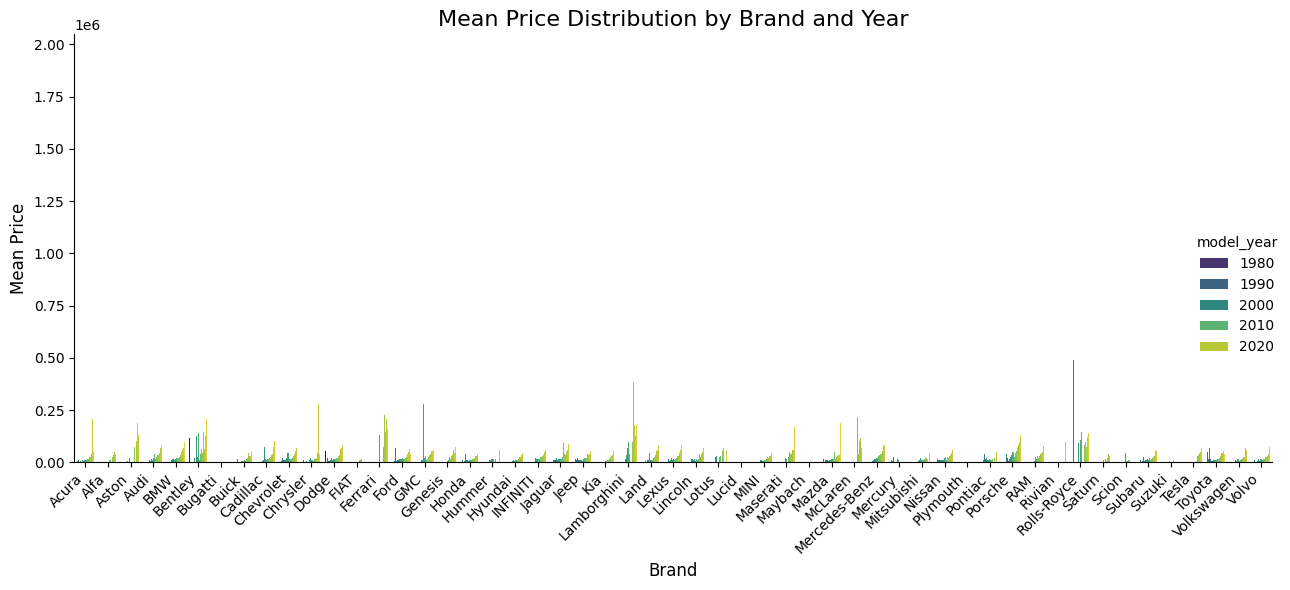

In [37]:
brand_year_mean_price = df.groupby(['brand', 'model_year'])['price'].mean().reset_index()

# Using a catplot with separate columns for each model year
sns.catplot(x='brand', y='price', hue='model_year', kind='bar', data=brand_year_mean_price, palette='viridis', height=6, aspect=2)

plt.title('Mean Price Distribution by Brand and Year', fontsize=16)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Mean Price', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Plotting Average Price per Year

This code calculates the average price for each model year and then plots the data with a line graph. The x-axis represents the model years, and the y-axis shows the average price, with markers for each data point.


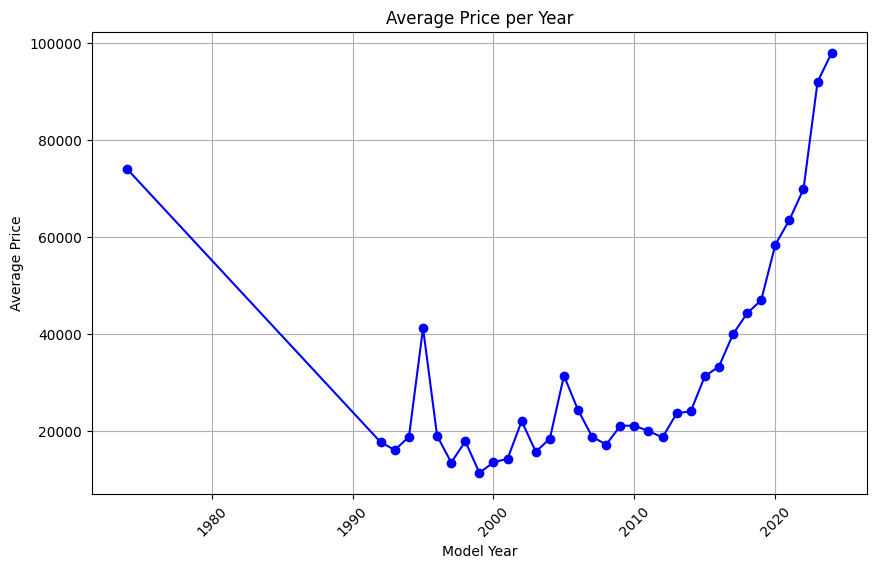

In [38]:
# Group by 'model_year' and calculate the mean price for each year
year_wise_avg_price = df.groupby('model_year')['price'].mean()

# Plotting the average price for each year
plt.figure(figsize=(10, 6))
plt.plot(year_wise_avg_price.index, year_wise_avg_price.values, marker='o', linestyle='-', color='b')
plt.title("Average Price per Year")
plt.xlabel("Model Year")
plt.ylabel("Average Price")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## Removing Outliers and Plotting Average Price per Year

This code first removes rows with 'model_year' less than 1990, considering them as outliers. Then, it calculates the average price for each model year and plots the data using a line graph, with model years on the x-axis and average prices on the y-axis.


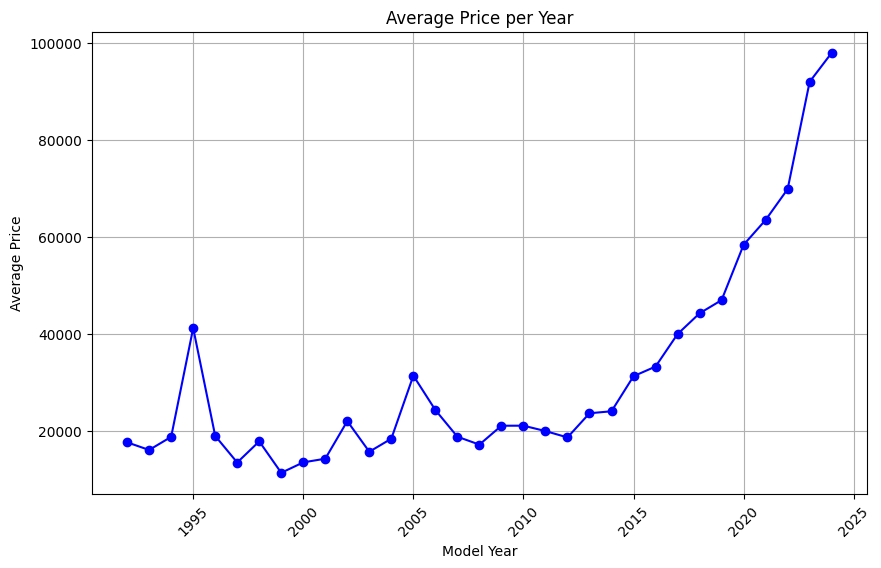

In [39]:
# Removing the rows with model_year less than 1990 as outliers
df = df[df['model_year'] >= 1990]

# Group by 'model_year' and calculate the mean price for each year
year_wise_avg_price = df.groupby('model_year')['price'].mean()

# Plotting the average price for each year
plt.figure(figsize=(10, 6))
plt.plot(year_wise_avg_price.index, year_wise_avg_price.values, marker='o', linestyle='-', color='b')
plt.title("Average Price per Year")
plt.xlabel("Model Year")
plt.ylabel("Average Price")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## Encoding Categorical Columns Based on Mean Price

This code calculates the mean price for each category in the 'brand', 'model', 'transmission', 'ext_col', and 'int_col' columns, then maps these categories to their corresponding mean prices. For the 'ext_col' and 'int_col', categories are ranked based on average price, with higher average prices receiving higher encoded values. This encoding is applied to the DataFrame to transform the categorical columns into numeric values based on their price.


In [40]:
# Target Encoding

# For 'brand'
mean_price_by_brand = df.groupby('brand')['price'].mean()
brand_mapping = mean_price_by_brand.to_dict()
df['brand'] = df['brand'].map(brand_mapping)

# For 'model'
mean_price_by_model = df.groupby('model')['price'].mean()
model_mapping = mean_price_by_model.to_dict()
df['model'] = df['model'].map(model_mapping)

# For 'transmission'
mean_price_by_transmission = df.groupby('transmission')['price'].mean()
transmission_mapping = mean_price_by_transmission.to_dict()
df['transmission'] = df['transmission'].map(transmission_mapping)

# For 'ext_col' and 'int_col'
ext_col_avg_price = df.groupby('ext_col')['price'].mean().sort_values()
int_col_avg_price = df.groupby('int_col')['price'].mean().sort_values()

ext_col_mapping = ext_col_avg_price.to_dict()
int_col_mapping = int_col_avg_price.to_dict()

df['ext_col'] = df['ext_col'].map(ext_col_mapping)
df['int_col'] = df['int_col'].map(int_col_mapping)

df.head()


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
0,38001.538101,42945.437500,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,60253.480436,37618.940971,26823.721317,None reported,11000
1,40425.078095,15631.257009,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,33160.346062,38909.767582,41152.659789,None reported,8250
2,34568.112930,14397.047619,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,24772.562000,26274.906977,27616.857511,None reported,15000
3,40425.078095,69502.713415,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,45805.581953,45251.596186,50007.954017,None reported,63500
4,17483.107143,10793.000000,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,30210.769350,37761.358637,41152.659789,None reported,7850


## Calculating the Age of Model Year

This code calculates the age of each car model by subtracting the model year from the current year. The 'model_year' column is then updated with the calculated age of the car. The mapping is created dynamically using the current year.


In [41]:
import datetime

cur_data = datetime.datetime.now()
current_year = cur_data.year

model_year_mapping = {year: age for year, age in zip(df['model_year'], current_year - df['model_year'] + 1)}

df['model_year'] = current_year - df['model_year'] + 1
df.rename(columns={'model_year': 'age'}, inplace=True)

df.head()



,brand,model,age,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
0,38001.538101,42945.437500,7,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,60253.480436,37618.940971,26823.721317,None reported,11000
1,40425.078095,15631.257009,18,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,33160.346062,38909.767582,41152.659789,None reported,8250
2,34568.112930,14397.047619,16,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,24772.562000,26274.906977,27616.857511,None reported,15000
3,40425.078095,69502.713415,3,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,45805.581953,45251.596186,50007.954017,None reported,63500
4,17483.107143,10793.000000,24,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,30210.769350,37761.358637,41152.659789,None reported,7850


## Extracting Engine Details

This code defines a function to extract various engine specifications (such as horsepower, engine displacement, cylinders, DOHC, and turbo) from the 'engine' column in the dataset. It uses regular expressions to parse these details from the engine string. The extracted information is then added as new columns to the DataFrame. The updated dataset is displayed in a tabular format.

### Engine Details Extracted:
- **HP**: Horsepower (e.g., 200HP)
- **Litre**: Engine displacement in liters (e.g., 2.5L)
- **Cylinders**: Engine configuration (e.g., I4, V6)
- **DOHC**: Presence of Double Overhead Cam (1 for present, 0 for absent)
- **Turbo**: Presence of Turbo (1 for present, 0 for absent)
- **Twin Turbo**: Presence of Twin Turbo (1 for present, 0 for absent)


In [42]:
# Combined function to extract engine details
def extract_engine_info(engine_string):
    # Initialize default values
    hp = None
    litres = None
    cylinders = -1
    dohc = 0
    turbo = 0
    twin_turbo = 0

    # Extract HP if available
    hp_match = re.search(r'(\d+(\.\d+)?)HP', engine_string)
    if hp_match:
        hp = float(hp_match.group(1))

    # Extract engine displacement in liters
    litres_match = re.search(r'(\d+(\.\d+)?)L', engine_string)
    if litres_match:
        litres = float(litres_match.group(1))

    # Extract cylinder information (I4, V6, Straight 6, or "6 Cylinder" etc.)
    cylinders_match = re.search(r'(I\d|V\d|Straight \d)', engine_string)
    if cylinders_match:
        cylinders = cylinders_match.group(1)
    else:
        # If no match found, look for a pattern like "6 Cylinder"
        cylinders_full_match = re.search(r'(\d+)\s*Cylinder', engine_string)
        if cylinders_full_match:
            cylinders = int(cylinders_full_match.group(1))

    # Identify if DOHC is present
    if 'DOHC' in engine_string:
        dohc = 1

    # Identify if Turbo or Twin Turbo is present
    if 'Twin Turbo' in engine_string:
        twin_turbo = 1
        turbo = 1  # Twin Turbo also means Turbo is present
    elif 'Turbo' in engine_string:
        turbo = 1

    # Return the parsed details along with DOHC and Turbo binary columns
    return pd.Series([hp, litres, cylinders, dohc, turbo, twin_turbo])

# Apply the function to the 'engine' column
df[['HP', 'Litre', 'Cylinders', 'DOHC', 'Turbo', 'Twin Turbo']] = df['engine'].apply(lambda x: extract_engine_info(x))

# Display the updated dataframe
print("Extracted engine details:")
print(tabulate(df.head(), headers='keys', tablefmt='pretty'))



Extracted engine details:
+---+-------------------+--------------------+-----+--------+-----------+-----------------------------------------------------------------------+--------------------+--------------------+--------------------+---------------+-------+-------+-------+------------+------+-------+------------+
|   |       brand       |       model        | age | milage | fuel_type |                                engine                                 |    transmission    |      ext_col       |      int_col       |   accident    | price |  HP   | Litre | Cylinders  | DOHC | Turbo | Twin Turbo |
+---+-------------------+--------------------+-----+--------+-----------+-----------------------------------------------------------------------+--------------------+--------------------+--------------------+---------------+-------+-------+-------+------------+------+-------+------------+
| 0 | 38001.53810063097 |     42945.4375     |  7  | 74349  | Gasoline  |             375.0HP 3.5L V6 Cy

## Dropping the 'engine' Column and Filling Missing Values

This code removes the 'engine' column from the DataFrame after extracting and storing the relevant engine details in separate columns, then applies the `fill_nan_with_mean_or_mode` function to fill any missing values in the dataset. The updated DataFrame is displayed with the missing values filled.



In [43]:
df=df.drop(['engine'],axis=1)
df = fill_nan_with_mean_or_mode(df)
df.head()

,brand,model,age,milage,fuel_type,transmission,ext_col,int_col,accident,price,HP,Litre,Cylinders,DOHC,Turbo,Twin Turbo
0,38001.538101,42945.437500,7,74349,Gasoline,60253.480436,37618.940971,26823.721317,None reported,11000,375.0,3.5,V6,0.0,0.0,0.0
1,40425.078095,15631.257009,18,80000,Gasoline,33160.346062,38909.767582,41152.659789,None reported,8250,300.0,3.0,Straight 6,0.0,0.0,0.0
2,34568.112930,14397.047619,16,91491,Gasoline,24772.562000,26274.906977,27616.857511,None reported,15000,300.0,4.2,8.0,0.0,0.0,0.0
3,40425.078095,69502.713415,3,2437,Hybrid,45805.581953,45251.596186,50007.954017,None reported,63500,335.0,3.0,Straight 6,0.0,0.0,0.0
4,17483.107143,10793.000000,24,111000,Gasoline,30210.769350,37761.358637,41152.659789,None reported,7850,200.0,3.8,V6,0.0,0.0,0.0


## Checking Unique Values in the 'Cylinders' Column

This code retrieves the unique values in the 'Cylinders' column and prints the number of unique values, along with the list of unique values.


In [44]:
my_list=df['Cylinders'].unique()
print(f"No. of Unique values in '{'Cylinders'}' column:",len(my_list))
print(my_list)


No. of Unique values in 'Cylinders' column: 14
['V6' 'Straight 6' 8.0 4.0 'I4' 6.0 5.0 'V8' 12.0 10.0 'V1' 'I6' 'I3' 3.0]


## Target Encoding for 'Cylinders' Column

This code performs target encoding on the 'Cylinders' column by mapping each unique value to the mean price of the corresponding 'Cylinders' group. The 'Cylinders' column is updated with these encoded values. The updated DataFrame is displayed.


In [45]:
# Target Encoding For Cylinders

mean_price_by_Cylinders = df.groupby('Cylinders')['price'].mean()
Cylinders_mapping = mean_price_by_Cylinders.to_dict()
df['Cylinders'] = df['Cylinders'].map(Cylinders_mapping)
df.head()

,brand,model,age,milage,fuel_type,transmission,ext_col,int_col,accident,price,HP,Litre,Cylinders,DOHC,Turbo,Twin Turbo
0,38001.538101,42945.437500,7,74349,Gasoline,60253.480436,37618.940971,26823.721317,None reported,11000,375.0,3.5,34149.696791,0.0,0.0,0.0
1,40425.078095,15631.257009,18,80000,Gasoline,33160.346062,38909.767582,41152.659789,None reported,8250,300.0,3.0,38849.827903,0.0,0.0,0.0
2,34568.112930,14397.047619,16,91491,Gasoline,24772.562000,26274.906977,27616.857511,None reported,15000,300.0,4.2,47268.624825,0.0,0.0,0.0
3,40425.078095,69502.713415,3,2437,Hybrid,45805.581953,45251.596186,50007.954017,None reported,63500,335.0,3.0,38849.827903,0.0,0.0,0.0
4,17483.107143,10793.000000,24,111000,Gasoline,30210.769350,37761.358637,41152.659789,None reported,7850,200.0,3.8,34149.696791,0.0,0.0,0.0


## Encoding 'accident' and 'fuel_type' Columns

This code applies `**Label Encoding**` to the 'accident' column by mapping the values 'At least 1 accident or damage reported' to 1 and 'None reported' to 0. It then applies `**One Hot Encoding**` to the 'fuel_type' column, creating binary columns for each fuel type, while dropping the first category to avoid multicollinearity.


In [46]:
# Label Encoding for 'accident' and One Hot Encoding for 'fuel_type'
df['accident'] = df['accident'].map({'At least 1 accident or damage reported': 1, 'None reported': 0})
df=pd.get_dummies(df, columns=['fuel_type'], prefix=['fuel_type'],drop_first=True)

## Displaying the Final List of Columns

This code prints the final list of column names present in the DataFrame after all transformations and encoding steps.


In [47]:
print("Final List of Columns our dataframe has:")
print(list(df.columns))

Final List of Columns our dataframe has:
['brand', 'model', 'age', 'milage', 'transmission', 'ext_col', 'int_col', 'accident', 'price', 'HP', 'Litre', 'Cylinders', 'DOHC', 'Turbo', 'Twin Turbo', 'fuel_type_E85 Flex Fuel', 'fuel_type_Gasoline', 'fuel_type_Hybrid', 'fuel_type_Plug-In Hybrid', 'fuel_type_not supported']


## Applying Log Transformation to 'Price' Column

This code applies a logarithmic transformation with base 10 to the 'price' column to help with better model fitting, especially if the data is skewed. The transformed price values are then updated in the DataFrame.


In [48]:
# Taking the log of the price with base 10 for better fitting of the model
df['price']=np.log(df['price'])/np.log(10)


## Scaling Numerical Columns with StandardScaler

This code selects numerical columns with more than 2 unique values and applies **StandardScaler** to standardize them (mean = 0, standard deviation = 1). The scaled values are then updated in the DataFrame. The updated DataFrame is displayed in a tabular format.


In [49]:
cols_to_scale = [
    col for col in df.select_dtypes(include=['number']).columns
    if df[col].nunique() > 2
]

# Apply StandardScaler to these columns
scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

print(tabulate(df.head(), headers='keys', tablefmt='pretty'))

+---+----------------------+---------------------+---------------------+----------------------+---------------------+----------------------+---------------------+----------+---------------------+----------------------+----------------------+----------------------+------+-------+------------+-------------------------+--------------------+------------------+--------------------------+-------------------------+
|   |        brand         |        model        |         age         |        milage        |    transmission     |       ext_col        |       int_col       | accident |        price        |          HP          |        Litre         |      Cylinders       | DOHC | Turbo | Twin Turbo | fuel_type_E85 Flex Fuel | fuel_type_Gasoline | fuel_type_Hybrid | fuel_type_Plug-In Hybrid | fuel_type_not supported |
+---+----------------------+---------------------+---------------------+----------------------+---------------------+----------------------+---------------------+----------+---

## Removing Low Correlation Columns

This code defines a function that removes columns from the DataFrame with a correlation coefficient less than a specified threshold (default is 0.2) with the target column ('price'). The correlation matrix is computed, and columns with low correlation are dropped. The function prints the list of removed columns and returns the updated DataFrame.


In [50]:
def remove_low_corr_columns(df, target_column, threshold=0.2):
    corr_matrix = df.corr()  # Compute the correlation matrix
    corr_with_target = corr_matrix[target_column]  # Get correlations with 'Price'

    # Keep only features with correlation above the threshold
    low_corr_features = corr_with_target[abs(corr_with_target) < threshold].index
    df = df.drop(columns=low_corr_features)

    print(f"Removed columns with correlation below {threshold}: {list(low_corr_features)}")
    return df

df = remove_low_corr_columns(df, target_column='price', threshold=0.008)

Removed columns with correlation below 0.008: []


## Splitting the Data into Training and Test Sets

This code splits the DataFrame into features (`X`) and target (`y`), then further divides them into training and test sets. 80% of the data is used for training, and 20% for testing. The `train_test_split` function from `sklearn.model_selection` is used, with a fixed `random_state` for reproducibility.


In [51]:
# Split the data into training and test sets (80% train, 20% test)
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

### **Linear Regression**
- A model that finds the best-fit line to predict the target variable based on input features.

In [ ]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict prices on the test data
y_pred = model.predict(X_test)
r2=r2_score(y_test, y_pred)

# Decode (inverse transform) y_test and y_pred for 'price' only using the original scale and mean for 'price'
price_index = cols_to_scale.index('price')

y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
y_pred_original = (y_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

y_pred_original=10**y_pred_original
y_test_original=10**y_test_original

# Now, calculate RMSE and R^2 on the original scale
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

# Compare the predicted and actual prices
comparison_df = pd.DataFrame({'Actual Price': y_test_original, 'Predicted Price': y_pred_original})
print(comparison_df.iloc[1:5])

Root Mean Squared Error: 47934.797
R-squared Score: 0.6281751394271851
       Actual Price  Predicted Price
31769  22389.001953     45247.175781
27105   8249.998047      8090.390137
22278  13700.002930     22496.832031
5822    4899.999512     10769.642578


## Explanation of Results

### 1. **Root Mean Squared Error (RMSE)**
- **47934.81**: The RMSE value indicates the average difference between the actual and predicted prices. A lower RMSE means better prediction accuracy, but in this case, the value suggests a moderate level of error in predicting the prices. This is the minimum RMSE that could be brought.

### 2. **R-squared Score (R²)**
- **0.63**: The R² score shows that approximately **63%** of the variance in the target variable (price) is explained by the model. A value closer to 1 would indicate better model performance, but 0.63 suggests a reasonably good fit, though there’s still significant room for improvement.

## **Model Used: Decision Tree Regressor**

A **Decision Tree Regressor** is a machine learning model that predicts continuous values by splitting the data into subsets based on feature values. It builds a tree-like structure where each node represents a decision based on a feature, and the leaves represent the predicted values. The model is used here to predict the price in a regression context.


In [ ]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

# Initialize the Decision Tree Regressor model
model = DecisionTreeRegressor(random_state=35)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict in the log-transformed scale
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Decode (inverse transform) y_test and y_pred for 'price' only using the original scale and mean for 'price'
price_index = cols_to_scale.index('price')

y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
y_pred_original = (y_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

y_pred_original=10**y_pred_original
y_test_original=10**y_test_original

# Now, calculate RMSE and R^2 on the original scale
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

# Compare the predicted and actual prices
comparison_df = pd.DataFrame({'Actual Price': y_test_original, 'Predicted Price': y_pred_original})
print(comparison_df.iloc[1:5])


Root Mean Squared Error: 95467.6844823443
R-squared Score: 0.2755840018677025
       Actual Price  Predicted Price
31769       22389.0          33500.0
27105        8250.0           4199.0
22278       13700.0          29000.0
5822         4900.0           7500.0


### Model Evaluation Results:

- **RMSE**: 95,467.68 - High error between predicted and actual prices.
- **R²**: 0.275 - The model explains only 27.5% of the price variance, indicating poor fit.
  
**Actual vs Predicted**:
- Significant discrepancies in predictions, with both overestimations and underestimations.
  
**Conclusion**: The model's performance is poor, and further improvements or different models may be needed.


### **K-Fold Cross Validation on Linear Regression**:
- **K-Fold** is a technique used to evaluate the performance of a model by splitting the dataset into **K** smaller subsets (or folds).
- The model is trained on **K-1** folds and tested on the remaining fold. This process is repeated **K** times, each time using a different fold as the test set.
- It helps to ensure that the model's performance is robust and not dependent on a single partition of the data.
- **In this case**:
  - The dataset is split into **5** folds (`k=5`).
  - The model is trained and evaluated 5 times, each time using a different fold as the test set and averaging the results (RMSE and R²).


In [ ]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

k = 5  # number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=33)
rmse_list = []
r2_list = []

# Loop over each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    # Decode (inverse transform) y_test and y_pred for 'price' only using the original scale and mean for 'price'
    price_index = cols_to_scale.index('price')
    y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
    y_pred_original = (y_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

    # Transform predictions back from log scale
    y_pred_original = 10 ** y_pred_original
    y_test_original = 10 ** y_test_original

    # Calculate RMSE and R-squared for the current fold
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)

    # Append the results for each fold
    rmse_list.append(rmse)
    r2_list.append(r2)

# Calculate the average RMSE and R^2 over all folds
average_rmse = np.mean(rmse_list)
average_r2 = np.mean(r2_list)

print("Average Root Mean Squared Error across folds:", average_rmse)
print("Average R-squared Score across folds:", average_r2)

Average Root Mean Squared Error across folds: 4660086.422540471
Average R-squared Score across folds: 0.6223398852186609


### Results Explanation:
- **Average Root Mean Squared Error (RMSE)**: 4,660,086.42
  - This high RMSE indicates that, on average, the model's predictions are significantly off from the actual values, suggesting poor predictive accuracy.
  
- **Average R-squared Score (R²)**: 0.62
  - The R² score shows that approximately **62%** of the variance in the target variable (price) is explained by the model. A value closer to 1 would indicate better model performance, but 0.62 suggests a reasonably good fit, though there’s still significant room for improvement

These results suggest that the model is not suitable for this data.


### **K-Fold Cross Validation on Decision Tree**:

In [ ]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

k = 5  # Define the number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=33)
rmse_list = []
r2_list = []

# Loop over each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    # Decode (inverse transform) y_test and y_pred for 'price' only using the original scale and mean for 'price'
    price_index = cols_to_scale.index('price')
    y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
    y_pred_original = (y_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

    # Transform predictions back from log scale
    y_pred_original = 10 ** y_pred_original
    y_test_original = 10 ** y_test_original

    # Calculate RMSE for the current fold
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)

    # Append the results for each fold
    rmse_list.append(rmse)
    r2_list.append(r2)

# Calculate the average RMSE and R^2 over all folds
average_rmse = np.mean(rmse_list)
average_r2 = np.mean(r2_list)

print("Average Root Mean Squared Error across folds:", average_rmse)
print("Average R-squared Score across folds:", average_r2)


Average Root Mean Squared Error across folds: 95100.77248880621
Average R-squared Score across folds: 0.29777048369597736


### Results Explanation:
- **Average Root Mean Squared Error (RMSE)**: 95,100.77
  - This high RMSE suggests that, on average, the model's predictions differ from the actual values by a large margin, indicating low predictive accuracy.

- **Average R-squared Score (R²)**: 0.29
  - The model explains only 29.7% of the price variance, indicating poor fit.

Overall, these results suggest that the model is not well-suited for this dataset.


### Model Architecture Explanation:
- **Sequential Model**: This is a simple feed-forward neural network.
- **Layers**:
  - **Dense Layer 1**: 50 neurons, ReLU activation, followed by Batch Normalization and Dropout (20%).
  - **Dense Layer 2**: 100 neurons, ReLU activation, with Batch Normalization and Dropout.
  - **Dense Layer 3**: 100 neurons, ReLU activation, with Batch Normalization and Dropout.
  - **Dense Layer 4**: 1000 neurons, ReLU activation, with Batch Normalization and Dropout.
  - **Output Layer**: 1 neuron for regression output.
- **Compilation**: Optimizer = Adam, Loss = Mean Absolute Error (MAE), Metric = RMSE.

This architecture is aimed at learning complex patterns in data while using Batch Normalization and Dropout to prevent overfitting.


In [ ]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

rmse = RootMeanSquaredError()
model = Sequential()
model.add(layers.Dense(units=50, input_dim=X_train.shape[1], activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=100, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=100, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=1000, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[rmse])

# Define callback
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, start_from_epoch=30),
]
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=my_callbacks)

history_df = pd.DataFrame(history.history)

# Predict on the validation data
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Decode (inverse transform) y_test and y_pred for 'price' only using the original scale and mean for 'price'
price_index = cols_to_scale.index('price')
y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
y_pred_original = (y_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

# Transform predictions back from log scale
y_pred_original = 10 ** y_pred_original
y_test_original = 10 ** y_test_original

# Calculate RMSE for the current fold
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)

print("R-squared Score on Validation Data:", r2)


Epoch 1/100
1250/1250 [==============================] - 8s 5ms/step - loss: 0.6345 - root_mean_squared_error: 0.8790 - val_loss: 0.4464 - val_root_mean_squared_error: 0.6408
Epoch 2/100
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4994 - root_mean_squared_error: 0.6911 - val_loss: 0.4794 - val_root_mean_squared_error: 0.6678
Epoch 3/100
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4886 - root_mean_squared_error: 0.6798 - val_loss: 0.4242 - val_root_mean_squared_error: 0.6080
Epoch 4/100
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4845 - root_mean_squared_error: 0.6763 - val_loss: 0.4164 - val_root_mean_squared_error: 0.5974
Epoch 5/100
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4718 - root_mean_squared_error: 0.6612 - val_loss: 0.4222 - val_root_mean_squared_error: 0.6026
Epoch 6/100
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4685 - root_mean_squared_error: 0.6569 - val_l

### R-squared Score Explanation:
- **R-squared Score**: 0.6566 on the validation data.
- **Interpretation**: This score means that approximately 65.6% of the variance in the target variable (e.g., price) can be explained by the model on the validation data.
- **Significance**: An R-squared value between 0 and 1 indicates that the model has captured a reasonable amount of the variability in the data but still leaves room for improvement.


### Model Architecture Explanation
- **Dynamic Dense Layers**: The model dynamically adjusts the number of hidden layers from 8 up to 15 to find the best performance. Each hidden layer has 64 neurons with ReLU activation.
- **Output Layer**: A single neuron with linear activation for continuous output (price prediction).
- **Early Stopping**: Stops training if validation loss doesn’t improve for 5 epochs, restoring the best weights.
- **Optimization**: Trained with Adam optimizer (learning rate = 0.001) and mean squared error (MSE) as the loss function.
- **Goal**: Finds the best layer configuration based on highest R-squared on validation data.


In [ ]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

# Dynamic model adjustment parameters
best_r2 = -np.inf
best_model = None
best_layers = 0
max_layers = 15  # Maximum number of layers to test
patience = 5  # Early stopping patience
learning_rate = 0.001

for num_layers in range(10, max_layers + 1):
    # Create a new model for each layer count
    model = Sequential()

    # Input layer
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

    # Adding hidden layers dynamically based on current `num_layers`
    for _ in range(num_layers - 2):
        model.add(Dense(64, activation='relu'))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mse'])

    # Train the model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

    # Evaluate on the test set
    y_pred = model.predict(X_test).flatten()
    current_r2 = r2_score(y_test, y_pred)

    # Check if this model has the best R² score so far
    if current_r2 > best_r2:
        best_r2 = current_r2
        best_model = model
        best_layers = num_layers
    else:
        continue
        # Stop if additional layers do not improve the R² score
        # break

# Display results of the best model
print(f"Best model has {best_layers} layers with R-squared: {best_r2}")

# Make predictions with the best model and evaluate
y_test_pred = best_model.predict(X_test).flatten()
r2 = r2_score(y_test, y_test_pred)


# Decode (inverse transform) y_test and y_pred for 'price' only using the original scale and mean for 'price'
price_index = cols_to_scale.index('price')

y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
y_pred_original = (y_test_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

y_pred_original=10**y_pred_original
y_test_original=10**y_test_original

# Now, calculate RMSE and R^2 on the original scale
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)

print("Root Mean Squared Error on Test Set:", np.sqrt(mse))
print("R-squared Score on Test Set:", r2)


# Compare the predicted and actual prices
comparison_df = pd.DataFrame({'Actual Price': y_test_original, 'Predicted Price': y_pred_original})
print(comparison_df.iloc[1:5])


313/313 [==============================] - 1s 1ms/step
Best model has 10 layers with R-squared: 0.6524417400360107
313/313 [==============================] - 0s 1ms/step
Root Mean Squared Error on Test Set: 48010.848
R-squared Score on Test Set: 0.6524417400360107
       Actual Price  Predicted Price
31769  22389.001953     47404.429688
27105   8249.998047      7569.163086
22278  13700.002930     20392.708984
5822    4899.999512      9811.651367


### Model Performance

- **Root Mean Squared Error (RMSE)**: 48010.84, which means on average, the model's predictions differ from the actual prices by approximately 49,068 units. A lower RMSE value indicates better model accuracy.

- **R-squared Score**: 0.6524, meaning the model explains 65.24% of the variance in the target variable (price). This suggests a good fit, but there is still room for improvement as the model doesn't capture all the variability in the data.



### Model Explanation
- **CatBoostRegressor**: A gradient boosting model designed for efficient handling of categorical features. It does not require manual encoding of categorical features, which simplifies the preprocessing step.
  
- **Categorical Features Handling**: Identifies features of object or category type (categorical) and uses them directly in the CatBoost model, which internally encodes them efficiently.
  
- **CatBoost Pool**: A specialized data structure in CatBoost that allows direct handling of categorical features, making training faster and more efficient.

- **Hyperparameters**:
  - `iterations=2000`: Number of boosting iterations (trees built).
  - `learning_rate=0.01`: A small learning rate for slower, steady improvements.
  - `depth=9`: Depth of each individual decision tree.
  - `l2_leaf_reg=1`: Regularization to prevent overfitting.
  - `eval_metric='RMSE'`: Evaluation metric used during training.
  - `early_stopping_rounds=10000`: Stops training early if no improvement is seen over the specified rounds.


In [ ]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
# Initialize and Train the CatBoostRegressor Model
# Creating CatBoost Pool for better handling of categorical features
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

# Initialize the CatBoostRegressor with some common parameters
model = CatBoostRegressor(
    iterations=2000,          # Number of boosting iterations
    learning_rate=0.01,       # Step size shrinkage to prevent overfitting
    depth=9,                  # Depth of the trees
    l2_leaf_reg=1,            # L2 regularization to prevent overfitting
    eval_metric='RMSE',       # Evaluation metric (Root Mean Squared Error)
    verbose=500,            # Print training progress every 100 iterations
    random_seed=42,
    early_stopping_rounds=10000  # Stop training if there's no improvement
)

# Fit the model on the training data
model.fit(train_pool, eval_set=test_pool, use_best_model=True)

# Step 3: Predict and Evaluate the Model
# Predict prices on the test data
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

price_index = cols_to_scale.index('price')

# Decode (inverse transform) y_test and y_pred for 'price' only using the original scale and mean for 'price'
y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
y_pred_original = (y_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

y_pred_original=10**y_pred_original
y_test_original=10**y_test_original

# Now, calculate RMSE on the original scale
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

# Compare the predicted and actual prices
comparison_df = pd.DataFrame({'Actual Price': y_test_original, 'Predicted Price': y_pred_original})
print(comparison_df.iloc[1:5])


0:	learn: 0.9965455	test: 0.9833799	best: 0.9833799 (0)	total: 11ms	remaining: 22.1s
500:	learn: 0.5703336	test: 0.5758303	best: 0.5758303 (500)	total: 3.88s	remaining: 11.6s
1000:	learn: 0.5543133	test: 0.5735538	best: 0.5735538 (1000)	total: 7.65s	remaining: 7.63s
1500:	learn: 0.5399042	test: 0.5730092	best: 0.5729604 (1468)	total: 11.6s	remaining: 3.85s
1999:	learn: 0.5268269	test: 0.5732036	best: 0.5729604 (1468)	total: 15.5s	remaining: 0us

bestTest = 0.5729603512
bestIteration = 1468

Shrink model to first 1469 iterations.
Root Mean Squared Error: 48121.05265933383
R-squared Score: 0.6646855459892694
       Actual Price  Predicted Price
31769  22389.001953     42995.865662
27105   8249.998047      6914.133418
22278  13700.002930     21204.495230
5822    4899.999512      8729.170609


### Model Performance Explanation
- **Root Mean Squared Error (RMSE):** 48,121.05
This means, on average, the model's predictions differ from the actual prices by approximately 48,121 units. A lower RMSE indicates higher accuracy, and this value shows the model's predictions are reasonably close to the actual values.

- **R-squared Score:** 0.6647
This means the model explains 66.47% of the variance in the target variable (price). While the model captures a significant portion of the variability, there is still some unexplained variation, indicating room for further improvement.

### Model Explanation

- **GradientBoostingRegressor**: A powerful ensemble model based on boosting. It builds multiple decision trees one after another, with each tree correcting the errors of the previous one. It is particularly good for handling non-linear relationships in regression tasks.

- **Random Seed**: The model is initialized with a `random_state=42` for reproducibility, ensuring that the results are consistent across different runs.




In [ ]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

model = GradientBoostingRegressor(random_state=42)
# Train the model on the training data
model.fit(X_train, y_train)

# Predict prices on the test data
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)


# Decode (inverse transform) y_test and y_pred for 'price' only using the original scale and mean for 'price'
price_index = cols_to_scale.index('price')

y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
y_pred_original = (y_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

y_pred_original=10**y_pred_original
y_test_original=10**y_test_original

# Now, calculate RMSE and R^2 on the original scale
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
# r2 = r2_score(y_test_original, y_pred_original)

print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

# Compare the predicted and actual prices
comparison_df = pd.DataFrame({'Actual Price': y_test_original, 'Predicted Price': y_pred_original})
print(comparison_df.iloc[1:5])

Root Mean Squared Error: 51361.57848955777
R-squared Score: 0.6738833216665119
       Actual Price  Predicted Price
11939   9449.997070      9297.273891
13314  65899.984375     38110.371598
13032  43998.984375     42039.847304
14729  86899.984375     77725.732555


### Model Performance

- **Root Mean Squared Error (RMSE)**: 51,361.07, indicating that, on average, the model's predictions deviate from the actual prices by approximately 51,361 units. A lower RMSE suggests better model accuracy, but this value still reflects substantial error.

- **R-squared Score**: 0.6739, meaning the model explains 67.39% of the variance in the target variable (price). This shows a decent fit, with the model explaining a good portion of the variability in the data.


### Model: XGBRegressor

- **Objective**: `reg:squarederror` indicates the model uses squared error for regression tasks.

- **Model Description**:
  - The `XGBRegressor` is an implementation of gradient boosting designed for regression tasks.
  - It builds an ensemble of trees sequentially, with each tree trying to correct the errors of the previous one. This helps in improving the predictive performance.



In [ ]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

model = XGBRegressor(objective='reg:squarederror')
# Train the model on the training data
model.fit(X_train, y_train)

# Predict prices on the test data
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Decode (inverse transform) y_test and y_pred for 'price' only using the original scale and mean for 'price'
price_index = cols_to_scale.index('price')

y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
y_pred_original = (y_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

y_pred_original=10**y_pred_original
y_test_original=10**y_test_original

# Now, calculate RMSE and R^2 on the original scale
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
# r2 = r2_score(y_test_original, y_pred_original)

print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

# Compare the predicted and actual prices
comparison_df = pd.DataFrame({'Actual Price': y_test_original, 'Predicted Price': y_pred_original})
print(comparison_df.iloc[1:5])

Root Mean Squared Error: 48275.637
R-squared Score: 0.6505571603775024
       Actual Price  Predicted Price
31769  22389.001953     37452.316406
27105   8249.998047      7554.517578
22278  13700.002930     23924.261719
5822    4899.999512      7297.818359


### Model Performance

- **Root Mean Squared Error (RMSE)**: 48275.63
  - The model's predictions differ from the actual values by an average of around 48275.63 units.

- **R-squared Score**: 0.6505  
  - The model explains approximately 65.05% of the variance in the data, indicating a moderate fit.


### **Model: K-Nearest Neighbors Regression (KNN)**
-  **KNN (K-Nearest Neighbors)**: A simple machine learning model that predicts the value of a data point based on the average of its 'K' nearest neighbors in the feature space. The model uses a **Manhattan distance metric** to measure similarity.
  
- **Purpose**: Predicts the target variable by averaging the values of the `k` nearest neighbors based on a distance metric.
- **Distance Metric**: **Manhattan distance** is used to compute the distance between points.


In [ ]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# Initialize the KNN model with a chosen number of neighbors, e.g., 5
knn_model = KNeighborsRegressor(n_neighbors=55,metric='euclidean')

# Train the model on the training data
knn_model.fit(X_train, y_train)

# Predict prices on the test data
y_pred = knn_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
# Decode (inverse transform) y_test and y_pred for 'price' only using the original scale and mean for 'price'
price_index = cols_to_scale.index('price')

y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
y_pred_original = (y_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

# Apply exponential transformation if needed
y_pred_original = 10**y_pred_original
y_test_original = 10**y_test_original

# Calculate RMSE and R^2 on the original scale
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

# Compare the predicted and actual prices
comparison_df = pd.DataFrame({'Actual Price': y_test_original, 'Predicted Price': y_pred_original})
print(comparison_df.iloc[1:5])


Root Mean Squared Error: 51953.613
R-squared Score: 0.654466986656189
       Actual Price  Predicted Price
11939   9449.997070      9939.156250
13314  65899.984375     38379.878906
13032  43998.980469     53502.199219
14729  86899.984375     69561.523438


### **Model Performance**
- **Root Mean Squared Error (RMSE)**: 51953.61 - The model's predictions deviate from the actual values by an average of approximately 51953.61 units.
- **R-squared Score**: 0.654 - The model explains around 65.44% of the variance in the target variable, suggesting a moderate fit.


### **Model Explanation**
- **Polynomial Features**: Generates higher-degree features based on the original features to capture nonlinear relationships in the data. Here, a polynomial degree of 2 is used.
- **Ridge Regression**: A linear regression technique that incorporates L2 regularization to prevent overfitting by penalizing large coefficients.

In [ ]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# Set up polynomial features and Ridge regression
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

ridge_model = Ridge(alpha=1.0)  # Regularization strength, adjust as needed
ridge_model.fit(X_train_poly, y_train)

# Predict prices on the test data
y_pred = ridge_model.predict(X_test_poly)

# Decode (inverse transform) y_test and y_pred for 'price' only using the original scale and mean for 'price'
price_index = cols_to_scale.index('price')

y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
y_pred_original = (y_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

# Apply exponential transformation if needed
y_pred_original = 10**y_pred_original
y_test_original = 10**y_test_original

# Calculate RMSE and R^2 on the original scale
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

# Compare the predicted and actual prices
comparison_df = pd.DataFrame({'Actual Price': y_test_original, 'Predicted Price': y_pred_original})
print(comparison_df.iloc[1:5])


Root Mean Squared Error: inf
R-squared Score: 0.13728821277618408
       Actual Price  Predicted Price
11939   9449.997070      9612.096680
13314  65899.984375     38026.656250
13032  43998.980469     56652.753906
14729  86899.984375     82021.921875


### **Model Performance Explanation**
- **Root Mean Squared Error (RMSE)**: The extremely high value (inf) indicates that the model's predictions are vastly different from the actual values, suggesting poor model performance.
- **R-squared Score**: The low value (0.137) indicates that only 13.72% of the variance in the data is explained by the model, further confirming the model's inability to capture the underlying patterns effectively.



### **Stacked Model Explanation**
1. **Base Learners**:
   - **Decision Tree Regressor**: A non-linear model that splits the data based on feature values to predict outcomes.
   - **Linear Regression**: A linear model that predicts a target variable based on the linear relationship between input features.
   - **Ridge Regression**: A regularized version of linear regression that penalizes large coefficients to avoid overfitting.

2. **Intermediate Model**:
   - **Random Forest Regressor**: An ensemble method that builds multiple decision trees and averages their predictions for better accuracy and generalization.

3. **Meta Model**:
   - **Gradient Boosting Regressor**: A boosting algorithm that builds models sequentially, where each new model corrects the errors of the previous ones.

4. **Stacking**: The predictions from the base learners are used as features for the meta-model, creating a more robust model by leveraging the strengths of each base model.

5. **Cross-Validation**: The model is evaluated using k-fold cross-validation, which helps to assess its performance across different subsets of the data, reducing overfitting risks.


In [ ]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# Define base-level models
base_learners = [
    ('decision_tree', DecisionTreeRegressor()),
    ('linear', LinearRegression()),
    ('ridge', Ridge())
]

# Intermediate level model (you can add more if needed)
intermediate_model = RandomForestRegressor()

# Meta model for stacking
meta_model = GradientBoostingRegressor()

# Define the stacked model
stacked_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_model,
    passthrough=True  # Pass the original features along with predictions from base models
)

# Initialize k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=33)
rmse_list = []
r2_list = []

# Loop over each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the stacked model
    stacked_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = stacked_model.predict(X_test)

    # Decode (inverse transform) y_test and y_pred for 'price' using the original scale and mean for 'price'
    price_index = cols_to_scale.index('price')
    y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
    y_pred_original = (y_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

    # Transform predictions back from log scale
    y_pred_original = 10 ** y_pred_original
    y_test_original = 10 ** y_test_original

    # Calculate RMSE and R² for the current fold
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Append the results for each fold
    rmse_list.append(rmse)
    r2_list.append(r2)

# Calculate the average RMSE and R² over all folds
average_rmse = np.mean(rmse_list)
average_r2 = np.mean(r2_list)

print("Average Root Mean Squared Error across folds:", average_rmse)
print("Average R-squared Score across folds:", average_r2)


Average Root Mean Squared Error across folds: 67307.11767203422
Average R-squared Score across folds: 0.6543665319194508


### **Model Performance Evaluation**
- **Average Root Mean Squared Error (RMSE)**: 67307.11
  - This indicates that on average, the model's predictions are off by approximately 67307 units, reflecting the magnitude of the prediction errors.
  
- **Average R-squared Score (R²)**: 0.6543
  - This means the model explains about 65.43% of the variance in the target variable, which shows a decent fit, but there is still room for improvement.

These metrics suggest the model is performing moderately well, with a reasonable level of error and a good explanation of the target's variance, though it may benefit from further tuning or add


# **Stacking Regression with Cross-Validation**

### **Steps**
1. **Data Preparation**: Convert features (`X`) and target (`y`) to `float32`, split data (80-20 train-test split).
2. **Base Models**:
   - DecisionTreeRegressor (non-linear patterns)
   - LinearRegression (linear patterns)
   - Ridge (regularized linear model)
3. **Meta Model**: GradientBoostingRegressor combines base model predictions.
4. **Final Model**: Ridge regressor trained on stacked model outputs.

### **Cross-Validation**
- Perform 5-fold CV:
  - Train the stacked model on folds.
  - Use its predictions as inputs for the final model.
  - Reverse scaling to compute metrics (RMSE, R²).
- Average metrics across folds for final evaluation.


In [ ]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# Define base-level models
base_learners = [
    ('decision_tree', DecisionTreeRegressor()),
    ('linear', LinearRegression()),
    ('ridge', Ridge())
]

# Meta model for stacking
meta_model = GradientBoostingRegressor()

# Define the stacked model
stacked_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_model,
    passthrough=True  # Pass the original features along with predictions from base models
)

# Final Decision Tree model to use output from the stacked model
final_model = Ridge()

# Initialize k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=33)
rmse_list = []
r2_list = []

# Loop over each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the stacked model
    stacked_model.fit(X_train, y_train)

    # Predict with the stacked model to use as inputs for the final model
    stacked_train_pred = stacked_model.predict(X_train).reshape(-1, 1)
    stacked_test_pred = stacked_model.predict(X_test).reshape(-1, 1)

    # Train the final Decision Tree model on the stacked model's predictions
    final_model.fit(stacked_train_pred, y_train)

    # Predict with the final model on the test data
    y_pred = final_model.predict(stacked_test_pred)

    # Decode (inverse transform) y_test and y_pred for 'price' using the original scale and mean for 'price'
    price_index = cols_to_scale.index('price')
    y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
    y_pred_original = (y_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

    # Transform predictions back from log scale
    y_pred_original = 10 ** y_pred_original
    y_test_original = 10 ** y_test_original

    # Calculate RMSE and R² for the current fold
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_original, y_pred_original)

    # Append the results for each fold
    rmse_list.append(rmse)
    r2_list.append(r2)

# Calculate the average RMSE and R² over all folds
average_rmse = np.mean(rmse_list)
average_r2 = np.mean(r2_list)

print("Average Root Mean Squared Error across folds:", average_rmse)
print("Average R-squared Score across folds:", average_r2)


Average Root Mean Squared Error across folds: 67085.59544441997
Average R-squared Score across folds: 0.14894297585146282


### **Model Performance Evaluation**

- **Average Root Mean Squared Error (RMSE)**: 66,085.98. This shows the average error in prediction magnitude. A higher value indicates more significant prediction errors, meaning the model might be struggling to accurately predict the target values.

- **Average R-squared Score (R²)**: 0.1575. This suggests that the model only explains around 15.75% of the variance in the data, which is quite low. It indicates that the model isn't capturing the underlying patterns well and might require improvements.

### **Model Explanation**
The **stacking model** incorporates multiple base models (Decision Tree, Linear Regression, Ridge) with a **Gradient Boosting** meta-model. Despite this combined approach, the performance might be limited by the base model choices, hyperparameters, or the complexity of the dataset.

### **Model Explanation**
This model is a **stacking ensemble** approach:
- **Base Models**: Decision Tree, Linear Regression, Ridge, and Lasso regression are used to make predictions based on the input data.
- **Intermediate Model**: A Random Forest Regressor is used to learn from the predictions made by the base models.
- **Meta Model**: A Gradient Boosting Regressor learns from the intermediate model's predictions, along with the original features.


In [ ]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# Define base-level models
base_learners = [
    ('decision_tree', DecisionTreeRegressor()),
    ('linear', LinearRegression()),
    ('ridge', Ridge()),
    ('lasso', Lasso())
]

# Intermediate model
intermediate_model = RandomForestRegressor()

# Meta model
meta_model = GradientBoostingRegressor()

# Initialize k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=1)
rmse_list = []
r2_list = []

# Loop over each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Base level predictions
    base_predictions = np.zeros((X_train.shape[0], len(base_learners)))
    base_test_predictions = np.zeros((X_test.shape[0], len(base_learners)))

    for idx, (name, model) in enumerate(base_learners):
        # Train each base model and get predictions for train and test
        model.fit(X_train, y_train)
        base_predictions[:, idx] = model.predict(X_train)
        base_test_predictions[:, idx] = model.predict(X_test)

    # Train the intermediate model on base model predictions
    intermediate_model.fit(base_predictions, y_train)

    # Get intermediate predictions for train and test
    intermediate_train_pred = intermediate_model.predict(base_predictions)
    intermediate_test_pred = intermediate_model.predict(base_test_predictions)

    # Concatenate intermediate predictions with original features
    meta_train_input = np.column_stack((intermediate_train_pred, X_train))
    meta_test_input = np.column_stack((intermediate_test_pred, X_test))

    # Train the meta model
    meta_model.fit(meta_train_input, y_train)

    # Predict with the meta model on the test data
    y_pred = meta_model.predict(meta_test_input)

    # Decode (inverse transform) y_test and y_pred for 'price' using the original scale and mean for 'price'
    price_index = cols_to_scale.index('price')
    y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
    y_pred_original = (y_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

    # Transform predictions back from log scale
    y_pred_original = 10 ** y_pred_original
    y_test_original = 10 ** y_test_original

    # Calculate RMSE and R² for the current fold
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Append the results for each fold
    rmse_list.append(rmse)
    r2_list.append(r2)

# Calculate the average RMSE and R² over all folds
average_rmse = np.mean(rmse_list)
average_r2 = np.mean(r2_list)

print("Average Root Mean Squared Error across folds:", average_rmse)
print("Average R-squared Score across folds:", average_r2)


Average Root Mean Squared Error across folds: 97495.38233331204
Average R-squared Score across folds: 0.3063946503661155


### **Model Performance Evaluation**

- **Average Root Mean Squared Error (RMSE)**: The RMSE of **97,495** indicates that the model's predictions deviate significantly from the actual prices. This means the model is making relatively large errors in predicting the target variable.

- **Average R-squared Score (R²)**: The R² score of **0.306** suggests that the model explains only **31%** of the variance in the target variable. This is relatively low, indicating that the model is not capturing much of the underlying patterns in the data.


### **Model Explanation**
This model uses **stacked generalization**:
1. **Base Models**:
   - **CatBoostRegressor**: A gradient boosting algorithm that handles categorical features efficiently.
   - **RandomForestRegressor**: A random forest model used to provide a strong baseline with its ensemble approach.
   - **Linear Regression**: A simple linear model to capture the overall relationship between features and the target.
   
2. **Meta Model**: A second **CatBoostRegressor** model takes the predictions from the base models and refines them to produce final predictions.


In [ ]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# Step 2: Define Base Models
base_models = [
    ('catboost', CatBoostRegressor(iterations=500, depth=6, learning_rate=0.05, verbose=0)),
    ('random_forest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('linear_regression', LinearRegression())
]

# Step 3: Train Base Models and Collect Predictions
train_meta_features = np.zeros((X_train.shape[0], len(base_models)))
test_meta_features = np.zeros((X_test.shape[0], len(base_models)))

for i, (name, model) in enumerate(base_models):
    model.fit(X_train, y_train)  # Train each base model
    train_meta_features[:, i] = model.predict(X_train)  # Predictions on train set
    test_meta_features[:, i] = model.predict(X_test)    # Predictions on test set

# Step 4: Train a Meta-Model on Top of the Base Model Predictions
meta_model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.05, verbose=0)
meta_model.fit(train_meta_features, y_train)

# Step 5: Make Predictions with the Stacked Model
final_predictions = meta_model.predict(test_meta_features)
y_pred = final_predictions
r2=r2_score(y_test, y_pred)

# Decode (inverse transform) y_test and y_pred for 'price' only using the original scale and mean for 'price'
price_index = cols_to_scale.index('price')

y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
y_pred_original = (y_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

y_pred_original=10**y_pred_original
y_test_original=10**y_test_original

# Now, calculate RMSE and R^2 on the original scale
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

# Compare the predicted and actual prices
comparison_df = pd.DataFrame({'Actual Price': y_test_original, 'Predicted Price': y_pred_original})
print(comparison_df.iloc[1:5])


Root Mean Squared Error: 53817.76305407528
R-squared Score: 0.6132882719831485
       Actual Price  Predicted Price
11939   9449.997070     11194.334614
13314  65899.984375     37977.990802
13032  43998.980469     48698.748382
14729  86899.984375     85994.214099


### **Model Performance Evaluation**

- **Root Mean Squared Error (RMSE)**: The RMSE of **53817.76** indicates that on average, the predicted prices deviate from the actual prices by this amount in the original scale.

- **R-squared Score (R²)**: The model has an R² of **0.613**, meaning it explains about 61.3% of the variance in the target variable (price). This is a decent fit but leaves room for improvement.

### 1. **Stacking Model 1: RF + GB + Ridge**
   - **Base Models**: Random Forest, Gradient Boosting
   - **Meta Model**: Ridge Regression
   - **Purpose**: Combines the strengths of tree-based models and regularization.

### 2. **Stacking Model 2: CatBoost + XGB + Lasso**
   - **Base Models**: CatBoost, XGBoost, Lasso
   - **Meta Model**: Ridge Regression
   - **Purpose**: Leverages advanced gradient boosting techniques and regularization.

### 3. **Stacking Model 3: LightGBM + Extra Trees + Linear**
   - **Base Models**: LightGBM, Extra Trees
   - **Meta Model**: Linear Regression
   - **Purpose**: Combines boosted tree methods with linear regression for simplicity and power.

### 4. **Stacking Model 4: NN + RF + ElasticNet**
   - **Base Models**: Neural Network, Random Forest, ElasticNet
   - **Meta Model**: Linear Regression
   - **Purpose**: Integrates deep learning, ensemble trees, and regularization.

### 5. **Voting Model: XGB + CatBoost + Linear**
   - **Base Models**: XGBoost, CatBoost, Linear Regression
   - **Meta Model**: Voting Regressor (combines predictions)
   - **Purpose**: Combines diverse models for a more robust prediction.


In [ ]:
import logging
df.columns = df.columns.str.replace(' ', '_')
warnings.filterwarnings("ignore", message="Found whitespace in feature_names")
logging.getLogger('lightgbm').setLevel(logging.CRITICAL)


In [ ]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# Define function to evaluate models
def evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Predict in log-transformed scale
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    # Decode (inverse transform) y_test and y_pred for 'price' only using the original scale and mean for 'price'
    price_index = cols_to_scale.index('price')

    y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
    y_pred_original = (y_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

    y_pred_original=10**y_pred_original
    y_test_original=10**y_test_original

    # Now, calculate RMSE and R^2 on the original scale
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)

    print(f"{model_name}")
    print("Root Mean Squared Error:", rmse)
    print("R-squared Score:", r2)
    print("\n")


# Ensemble Models

# Model 1: Random Forest + Gradient Boosting + Ridge Regression (Stacking)
stacking_model_1 = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
        ('ridge', Ridge())
    ],
    final_estimator=Ridge()
)

# Model 2: CatBoost + XGBoost + Lasso Regression (Stacking)
stacking_model_2 = StackingRegressor(
    estimators=[
        ('catboost', CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, verbose=0, random_state=42)),
        ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42)),
        ('lasso', Lasso(alpha=0.1))
    ],
    final_estimator=Ridge()
)

# Model 3: LightGBM + Extra Trees + Linear Regression (Stacking)
stacking_model_3 = StackingRegressor(
    estimators=[
        ('lgbm', LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42,force_col_wise=True)),
        ('extra_trees', ExtraTreesRegressor(n_estimators=100, random_state=42)),
        ('linear', LinearRegression())
    ],
    final_estimator=LinearRegression()
)

# Model 4: Neural Network + Random Forest + ElasticNet (Stacking)
stacking_model_4 = StackingRegressor(
    estimators=[
        ('nn', MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('elasticnet', ElasticNet(alpha=0.1, l1_ratio=0.5))
    ],
    final_estimator=LinearRegression()
)

# Model 5: Voting Regressor with XGBoost + CatBoost + Linear Regression
voting_model = VotingRegressor(
    estimators=[
        ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42)),
        ('catboost', CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, verbose=0, random_state=42)),
        ('linear', LinearRegression())
    ]
)

# Evaluate Each Model
print("Model Evaluation Results:\n")
evaluate_model(stacking_model_1, "Stacking Model 1: RF + GB + Ridge")
evaluate_model(stacking_model_2, "Stacking Model 2: CatBoost + XGB + Lasso")
evaluate_model(stacking_model_3, "Stacking Model 3: LightGBM + Extra Trees + Linear")
evaluate_model(stacking_model_4, "Stacking Model 4: Neural Network + RF + ElasticNet")
evaluate_model(voting_model, "Voting Model: XGB + CatBoost + Linear")


Model Evaluation Results:

Stacking Model 1: RF + GB + Ridge
Root Mean Squared Error: 51018.343976384815
R-squared Score: 0.6794009014671418


Stacking Model 2: CatBoost + XGB + Lasso
Root Mean Squared Error: 51276.94616865542
R-squared Score: 0.678709267100509


[LightGBM] [Info] Total Bins 1222
[LightGBM] [Info] Number of data points in the train set: 39995, number of used features: 18
[LightGBM] [Info] Start training from score 0.001000
[LightGBM] [Info] Total Bins 1204
[LightGBM] [Info] Number of data points in the train set: 31996, number of used features: 18
[LightGBM] [Info] Start training from score 0.001908
[LightGBM] [Info] Total Bins 1206
[LightGBM] [Info] Number of data points in the train set: 31996, number of used features: 18
[LightGBM] [Info] Start training from score -0.001883
[LightGBM] [Info] Total Bins 1203
[LightGBM] [Info] Number of data points in the train set: 31996, number of used features: 18
[LightGBM] [Info] Start training from score 0.002549
[LightGBM] [Inf

### Model Evaluation Results (Updated):

#### **Stacking Model 1: RF + GB + Ridge**
- **RMSE**: 51,018.34
- **R-squared**: 0.6794

#### **Stacking Model 2: CatBoost + XGB + Lasso**
- **RMSE**: 51,276.95
- **R-squared**: 0.6787

#### **Stacking Model 3: LightGBM + Extra Trees + Linear**
- **RMSE**: 50,771.66
- **R-squared**: 0.6801

#### **Stacking Model 4: Neural Network + RF + ElasticNet**
- **RMSE**: 48,787.41
- **R-squared**: 0.6744

#### **Voting Model: XGB + CatBoost + Linear**
- **RMSE**: 49,378.54
- **R-squared**: 0.6783

Each model was evaluated using **Root Mean Squared Error (RMSE)** and **R-squared**. Training logs for LightGBM indicate consistent data handling with used features across subsets. The results showcase improvement, particularly in **Stacking Model 4**, which exhibits the lowest RMSE.


### Models:

- **Linear Regression**: Fits a linear relationship between input variables and the target variable.
- **Ridge Regression**: A type of linear regression with L2 regularization to prevent overfitting.
- **Lasso Regression**: Linear regression with L1 regularization, encouraging sparsity in the coefficients.
- **ElasticNet Regression**: Combines both L1 and L2 regularization, balancing Ridge and Lasso.
- **Random Forest**: Ensemble model using multiple decision trees to improve prediction accuracy.
- **Gradient Boosting**: Sequential ensemble technique where each model corrects the errors of the previous one.
- **K-Nearest Neighbors**: A non-parametric algorithm that predicts based on the k-nearest data points.
- **Support Vector Regressor**: A model that uses a hyperplane to fit the data in high-dimensional space.
- **Neural Network**: A computational model inspired by the human brain to model complex relationships.
- **XGBoost**: Optimized boosting algorithm that focuses on performance and speed.


In [ ]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Support Vector Regressor": SVR(),
    "Neural Network": MLPRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Initialize dictionary to store results
results = {}

# Iterate over each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

        # Predict in the log-transformed scale
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    # Decode (inverse transform) y_test and y_pred for 'price' only using the original scale and mean for 'price'
    price_index = cols_to_scale.index('price')

    y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
    y_pred_original = (y_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

    y_pred_original=10**y_pred_original
    y_test_original=10**y_test_original

    # Now, calculate RMSE and R^2 on the original scale
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)

    # Print the results for each model
    print(f"{model_name}")
    print("Root Mean Squared Error:", rmse)
    print("R-squared Score:", r2)
    print()
    # Compare the predicted and actual prices
    # comparison_df = pd.DataFrame({'Actual Price': y_test_original, 'Predicted Price': y_pred_original})
    # print(comparison_df.iloc[1:5])
    # Store the results
    results[model_name] = {
        "RMSE": rmse,
        "R^2": r2
    }


# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results).T
print("\nSummary of Model Performance:")
print(results_df)


Linear Regression
Root Mean Squared Error: 47934.797
R-squared Score: 0.6281751394271851

Ridge Regression
Root Mean Squared Error: 47935.37
R-squared Score: 0.6281453371047974

Lasso Regression
Root Mean Squared Error: 55333.6
R-squared Score: -2.2292137145996094e-05

ElasticNet Regression
Root Mean Squared Error: 54363.55
R-squared Score: 0.18111765384674072

Random Forest
Root Mean Squared Error: 48467.45000729604
R-squared Score: 0.6345903663258341

Gradient Boosting
Root Mean Squared Error: 48068.26159969255
R-squared Score: 0.6593694984882976

K-Nearest Neighbors
Root Mean Squared Error: 49066.617
R-squared Score: 0.592215895652771

Support Vector Regressor
Root Mean Squared Error: 48969.456347459294
R-squared Score: 0.6531553469466719

Neural Network
Root Mean Squared Error: 48521.117
R-squared Score: 0.6525853872299194

XGBoost
Root Mean Squared Error: 48275.637
R-squared Score: 0.6505571603775024


Summary of Model Performance:
                                  RMSE       R^2


### Model Performance Summary (Updated)

1. **Linear Regression**:  
   - **RMSE**: 47,934.80  
   - **R²**: 0.6282  
   - Model fits decently, but there is room for improvement.

2. **Ridge Regression**:  
   - **RMSE**: 47,935.37  
   - **R²**: 0.6281  
   - Very similar to Linear Regression with minimal effect of regularization.

3. **Lasso Regression**:  
   - **RMSE**: 55,333.60  
   - **R²**: -0.0000  
   - Performs poorly, likely due to excessive regularization causing underfitting.

4. **ElasticNet Regression**:  
   - **RMSE**: 54,363.55  
   - **R²**: 0.1811  
   - Shows weak performance, indicating that the L1 and L2 regularization balance is suboptimal.

5. **Random Forest**:  
   - **RMSE**: 48,467.45  
   - **R²**: 0.6346  
   - Good performance with some improvement over simpler regression models.

6. **Gradient Boosting**:  
   - **RMSE**: 48,068.26  
   - **R²**: 0.6594  
   - Outperforms Random Forest, benefiting from sequential learning.

7. **K-Nearest Neighbors**:  
   - **RMSE**: 49,066.62  
   - **R²**: 0.5922  
   - Relatively weaker performance, likely due to sensitivity to outliers.

8. **Support Vector Regressor**:  
   - **RMSE**: 48,969.46  
   - **R²**: 0.6532  
   - Competitive performance, slightly worse than Gradient Boosting but still strong.

9. **Neural Network**:  
   - **RMSE**: 48,521.12  
   - **R²**: 0.6526  
   - Performs comparably to Gradient Boosting and Random Forest.

10. **XGBoost**:  
    - **RMSE**: 48,275.64  
    - **R²**: 0.6506  
    - Good performance, slightly behind Gradient Boosting and Random Forest.

### Key Takeaways:
- **Best Performance**: Gradient Boosting achieves the highest R² (0.659) with the lowest RMSE.  
- **Worst Performance**: Lasso Regression, with a negative R², indicating significant underfitting.  
- **General Trend**: Ensemble methods like **Random Forest** and **Gradient Boosting** outperform simpler models like **Linear Regression** and **Lasso**. Neural Networks, **XGBoost**, and **Support Vector Regressor** are also competitive but not the top performers in this dataset.


### Stacking Model Explanation:

1. **Base Models**:  
   A variety of models are defined to be used as base models:
   - Linear Regression, Ridge, Lasso, ElasticNet (Linear models)
   - Random Forest, Gradient Boosting (Ensemble models)
   - K-Nearest Neighbors, Support Vector Regressor (Instance-based models)
   - XGBoost (Boosting method)
   
   These base models will be trained on the data and their predictions will serve as features for the meta-model.

2. **Meta Model**:  
   - A **Linear Regression** model is chosen as the meta-model, which will be trained on the predictions of the base models.

3. **StackingRegressor Class**:  
   - A custom class that performs stacking, where:
     - **KFold Cross-validation** is used to train base models on different folds of the data and collect out-of-fold predictions.
     - These out-of-fold predictions are used as inputs to train the meta-model.
     - The meta-model is then used to make final predictions by combining the base model outputs.


   
### Summary:
- **Stacked Model** utilizes the strengths of various models by combining their predictions using a meta-model, potentially improving performance compared to individual models.


In [29]:
# Convert all columns in X and y to float32
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

# Define base models
base_models = [
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge()),
    ("Lasso Regression", Lasso()),
    ("ElasticNet", ElasticNet()),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42)),
    ("K-Nearest Neighbors", KNeighborsRegressor()),
    ("Support Vector Regressor", SVR()),
    ("XGBoost", XGBRegressor(objective='reg:squarederror', random_state=42))
]

# Meta model (to be trained on predictions of base models)
meta_model = LinearRegression()

# Class for stacking model
class StackingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_features = np.zeros((X.shape[0], len(self.base_models)))

        # Train each base model and collect out-of-fold predictions
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)

        for i, (name, model) in enumerate(self.base_models):
            for train_idx, holdout_idx in kfold.split(X, y):
                instance = model
                instance.fit(X[train_idx], y[train_idx])
                self.base_models_[i].append(instance)
                self.meta_features[holdout_idx, i] = instance.predict(X[holdout_idx])

        # Fit meta-model on out-of-fold predictions of base models
        self.meta_model.fit(self.meta_features, y)
        return self

    def predict(self, X):
        meta_features_test = np.zeros((X.shape[0], len(self.base_models)))

        # Generate predictions for each base model and average them
        for i, base_models in enumerate(self.base_models_):
            meta_features_test[:, i] = np.column_stack([
                model.predict(X) for model in base_models
            ]).mean(axis=1)

        # Final prediction using meta-model
        return self.meta_model.predict(meta_features_test)

# Initialize the stacked model
stacked_model = StackingRegressor(base_models=base_models, meta_model=meta_model)

# Train the stacked model
stacked_model.fit(X_train.values, y_train.values)

# Predict and invert the log transformation
y_pred = stacked_model.predict(X_test)
r2 = r2_score(y_test, y_pred)


# Decode (inverse transform) y_test and y_pred for 'price' only using the original scale and mean for 'price'
price_index = cols_to_scale.index('price')

y_test_original = (y_test * scaler.scale_[price_index]) + scaler.mean_[price_index]
y_pred_original = (y_pred * scaler.scale_[price_index]) + scaler.mean_[price_index]

y_pred_original=10**y_pred_original
y_test_original=10**y_test_original

# Now, calculate RMSE and R^2 on the original scale
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

# Compare the predicted and actual prices
comparison_df = pd.DataFrame({'Actual Price': y_test_original, 'Predicted Price': y_pred_original})
print(comparison_df.iloc[1:5])

print(f"Stacked Model - RMSE: {rmse:.2f}, R^2: {r2:.4f}")


Root Mean Squared Error: 48054.23633838259
R-squared Score: 0.664184864498512
       Actual Price  Predicted Price
31769  22389.000000     41943.627510
27105   8249.998047      6958.763484
22278  13700.002930     21906.364223
5822    4899.999512      8485.527426
Stacked Model - RMSE: 48054.24, R^2: 0.6642


### Model Evaluation Metrics

1. **Root Mean Squared Error (RMSE):**  
   - The RMSE value of **48054.24** indicates the standard deviation of prediction errors (residuals). A lower RMSE signifies better predictive accuracy.

2. **R-squared (R²) Score:**  
   - The R² value of **0.6642** suggests that approximately **66.42%** of the variance in the target variable is explained by the model. Higher values closer to 1 indicate better fit.


### Preparation for submission.csv

In [181]:
# Load the testing dataset
data_url_final = '/content/Used_car_prediction/testing_data.csv'
df_test = pd.read_csv(data_url_final)

# Load the training dataset
data_url_train = '/content/Used_car_prediction/training_data.csv'
df_train = pd.read_csv(data_url_train)

id_start_test = df_test['id'].iloc[0]

# Display the first few rows in a tabular format
print(tabulate(df_test.head(), headers='keys', tablefmt='pretty'))

+---+--------------+------------+-------+--------+--------------------------------------------+------------+--------+-----------+-----------------------------------------------+--------------------------------+---------+---------+----------------------------------------+-------------+
|   | Unnamed: 0.1 | Unnamed: 0 |  id   | brand  |                   model                    | model_year | milage | fuel_type |                    engine                     |          transmission          | ext_col | int_col |                accident                | clean_title |
+---+--------------+------------+-------+--------+--------------------------------------------+------------+--------+-----------+-----------------------------------------------+--------------------------------+---------+---------+----------------------------------------+-------------+
| 0 |      0       |   50001    | 50001 | Nissan |                  Xterra S                  |    2008    | 167000 | Gasoline  | 261.0HP 4.0L

In [182]:
if 'Unnamed: 0.1' in df_test.columns:
    df_test = df_test.drop(columns='Unnamed: 0.1')
if 'Unnamed: 0' in df_test.columns:
    df_test = df_test.drop(columns='Unnamed: 0')

if 'Unnamed: 0' in df_train.columns:
    df_train = df_train.drop(columns='Unnamed: 0')

# Replace '–' and None with NaN
df_test.replace('–', np.nan, inplace=True)
df_test.replace([None], np.nan, inplace=True)

# Replace '–' and None with NaN (if '–' or 'None' is used as a placeholder for missing data)
df_train.replace('–', np.nan, inplace=True)
df_train.replace([None], np.nan, inplace=True)

# Check for any missing values in df_test
print("Number of NaN values present in df_test:")
print(df_test.isna().sum())  # Count all NaN values in each column


Number of NaN values present in df_test:
id               0
brand            0
model            0
model_year       0
milage           0
fuel_type       16
engine          23
transmission     1
ext_col          1
int_col         91
accident         0
clean_title      0
dtype: int64


In [183]:
def fill_nan_with_train_statistics(df, train_means_modes):
    # Replace placeholders with NaN
    df.replace([-1, None, '–'], np.nan, inplace=True)

    # Fill NaN using provided statistics
    for col, value in train_means_modes.items():
        if col not in df.columns:
          continue
        df[col] = df[col].fillna(value)
    return df


# Replace placeholders in df_train
df_train.replace([-1, None, '–'], np.nan, inplace=True)

# Compute mean/mode for df_train
train_means_modes = {}
for col in df_train.columns:
    if df_train[col].dtype in ['float64', 'int64']:
        train_means_modes[col] = df_train[col].mean()
    else:
        train_means_modes[col] = df_train[col].mode()[0]

# Fill NaN in df_train using its own statistics
df_train = fill_nan_with_train_statistics(df_train, train_means_modes)

# Fill NaN in df_test using df_train's statistics
df_test = fill_nan_with_train_statistics(df_test, train_means_modes)


In [184]:
# Collect unique values information in a list of lists
unique_values_info = []

for col in df_test.columns:
    unique_count = len(df_test[col].unique())
    unique_values_info.append([col, unique_count])

# Print the unique values information in tabular format
print(tabulate(unique_values_info, headers=["Column", "No. of Unique Values"], tablefmt="pretty"))


+--------------+----------------------+
|    Column    | No. of Unique Values |
+--------------+----------------------+
|      id      |         4272         |
|    brand     |          48          |
|    model     |         1129         |
|  model_year  |          33          |
|    milage    |         1634         |
|  fuel_type   |          5           |
|    engine    |         699          |
| transmission |          35          |
|   ext_col    |         100          |
|   int_col    |          54          |
|   accident   |          2           |
| clean_title  |          1           |
+--------------+----------------------+


In [185]:
# Drop the 'clean_title' column
df_test.drop(['clean_title'], axis=1, inplace=True)
df_train.drop(['clean_title'], axis=1, inplace=True)

# Drop the 'id' column
df_test.drop(columns=['id'],inplace=True)
df_train.drop(columns=['id'],inplace=True)

df_train = df_train[df_train['model_year'] >= 1990]

In [186]:
# Target Encoding

# For 'brand'
mean_price_by_brand = df_train.groupby('brand')['price'].mean()
brand_mapping = mean_price_by_brand.to_dict()
df_train['brand'] = df_train['brand'].map(brand_mapping)

# For 'model'
mean_price_by_model = df_train.groupby('model')['price'].mean()
model_mapping = mean_price_by_model.to_dict()
df_train['model'] = df_train['model'].map(model_mapping)

# For 'transmission'
mean_price_by_transmission = df_train.groupby('transmission')['price'].mean()
transmission_mapping = mean_price_by_transmission.to_dict()
df_train['transmission'] = df_train['transmission'].map(transmission_mapping)

# For 'ext_col' and 'int_col'
ext_col_avg_price = df_train.groupby('ext_col')['price'].mean().sort_values()
int_col_avg_price = df_train.groupby('int_col')['price'].mean().sort_values()

ext_col_mapping = ext_col_avg_price.to_dict()
int_col_mapping = int_col_avg_price.to_dict()

df_train['ext_col'] = df_train['ext_col'].map(ext_col_mapping)
df_train['int_col'] = df_train['int_col'].map(int_col_mapping)

# Apply the stored mappings to df_test
df_test['brand'] = df_test['brand'].map(brand_mapping)
df_test['model'] = df_test['model'].map(model_mapping)
df_test['transmission'] = df_test['transmission'].map(transmission_mapping)
df_test['ext_col'] = df_test['ext_col'].map(ext_col_mapping)
df_test['int_col'] = df_test['int_col'].map(int_col_mapping)

# Verify changes
print(tabulate(df_test.head(), headers='keys', tablefmt='pretty'))


+---+--------------------+--------------------+------------+--------+-----------+-----------------------------------------------+--------------------+--------------------+--------------------+----------------------------------------+
|   |       brand        |       model        | model_year | milage | fuel_type |                    engine                     |    transmission    |      ext_col       |      int_col       |                accident                |
+---+--------------------+--------------------+------------+--------+-----------+-----------------------------------------------+--------------------+--------------------+--------------------+----------------------------------------+
| 0 | 24153.342036553524 | 14257.45871559633  |    2008    | 167000 | Gasoline  | 261.0HP 4.0L V6 Cylinder Engine Gasoline Fuel | 30210.755710865204 | 30863.676513723025 | 26823.721317157713 | At least 1 accident or damage reported |
| 1 | 37397.35101289135  | 34056.566666666666 |    2018    | 525

In [187]:
df_test['model_year'] = current_year - df_test['model_year'] + 1
df_test.rename(columns={'model_year': 'age'}, inplace=True)

df_train['model_year'] = current_year - df_train['model_year'] + 1
df_train.rename(columns={'model_year': 'age'}, inplace=True)


In [188]:
df_test[['HP', 'Litre', 'Cylinders', 'DOHC', 'Turbo', 'Twin Turbo']] = df_test['engine'].apply(lambda x: extract_engine_info(x))
df_test=df_test.drop(['engine'],axis=1)
# Verify changes
print(tabulate(df_test.head(), headers='keys', tablefmt='pretty'))

+---+--------------------+--------------------+-----+--------+-----------+--------------------+--------------------+--------------------+----------------------------------------+-------+-------+-----------+------+-------+------------+
|   |       brand        |       model        | age | milage | fuel_type |    transmission    |      ext_col       |      int_col       |                accident                |  HP   | Litre | Cylinders | DOHC | Turbo | Twin Turbo |
+---+--------------------+--------------------+-----+--------+-----------+--------------------+--------------------+--------------------+----------------------------------------+-------+-------+-----------+------+-------+------------+
| 0 | 24153.342036553524 | 14257.45871559633  | 17  | 167000 | Gasoline  | 30210.755710865204 | 30863.676513723025 | 26823.721317157713 | At least 1 accident or damage reported | 261.0 |  4.0  |    V6     | 0.0  |  0.0  |    0.0     |
| 1 | 37397.35101289135  | 34056.566666666666 |  7  | 52500 

In [189]:
df_train[['HP', 'Litre', 'Cylinders', 'DOHC', 'Turbo', 'Twin Turbo']] = df_train['engine'].apply(lambda x: extract_engine_info(x))
df_train=df_train.drop(['engine'],axis=1)

# Replace placeholders in df_train
df_train.replace([-1, None, '–'], np.nan, inplace=True)

# Compute mean/mode for df_train
train_means_modes = {}
for col in df_train.columns:
    if df_train[col].dtype in ['float64', 'int64']:
        train_means_modes[col] = df_train[col].mean()
    else:
        train_means_modes[col] = df_train[col].mode()[0]

# Fill NaN in df_train using its own statistics
df_train = fill_nan_with_train_statistics(df_train, train_means_modes)

# Fill NaN in df_test using df_train's statistics
df_test = fill_nan_with_train_statistics(df_test, train_means_modes)


In [190]:
my_list=df_test['Cylinders'].unique()
print(f"No. of Unique values in '{'Cylinders'}' column:",len(my_list))
print(my_list)


No. of Unique values in 'Cylinders' column: 14
['V6' 4.0 8.0 'Straight 6' 'V8' 'I4' 5.0 6.0 12.0 3.0 10.0 'V1' 'I6' 'I3']


In [191]:
# Target Encoding For Cylinders

mean_price_by_Cylinders = df_train.groupby('Cylinders')['price'].mean()
Cylinders_mapping = mean_price_by_Cylinders.to_dict()
df_train['Cylinders'] = df_train['Cylinders'].map(Cylinders_mapping)

df_test['Cylinders'] = df_test['Cylinders'].map(Cylinders_mapping)

In [192]:
# Label encoding for 'accident'and one hot encoding for 'fuel_type'
df_test['accident'] = df_test['accident'].map({'At least 1 accident or damage reported': 1, 'None reported': 0})
df_test = pd.get_dummies(df_test, columns=['fuel_type'], prefix=['fuel_type'], drop_first=True)

df_train['accident'] = df_train['accident'].map({'At least 1 accident or damage reported': 1, 'None reported': 0})
df_train = pd.get_dummies(df_train, columns=['fuel_type'], prefix=['fuel_type'], drop_first=True)

df_train['price']=np.log(df_train['price'])/np.log(10)


In [193]:
print(df_test.columns)
print()
print(df_train.columns)

Index(['brand', 'model', 'age', 'milage', 'transmission', 'ext_col', 'int_col',
       'accident', 'HP', 'Litre', 'Cylinders', 'DOHC', 'Turbo', 'Twin Turbo',
       'fuel_type_E85 Flex Fuel', 'fuel_type_Gasoline', 'fuel_type_Hybrid',
       'fuel_type_Plug-In Hybrid'],
      dtype='object')

Index(['brand', 'model', 'age', 'milage', 'transmission', 'ext_col', 'int_col',
       'accident', 'price', 'HP', 'Litre', 'Cylinders', 'DOHC', 'Turbo',
       'Twin Turbo', 'fuel_type_E85 Flex Fuel', 'fuel_type_Gasoline',
       'fuel_type_Hybrid', 'fuel_type_Plug-In Hybrid',
       'fuel_type_not supported'],
      dtype='object')


In [194]:
# Convert all boolean columns to integers (0 and 1) in df_train
df_train = df_train.applymap(lambda x: 1 if x is True else (0 if x is False else x))

# Convert all boolean columns to integers (0 and 1) in df_test
df_test = df_test.applymap(lambda x: 1 if x is True else (0 if x is False else x))

<ipython-input-194-a921c02b3402>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_train = df_train.applymap(lambda x: 1 if x is True else (0 if x is False else x))
<ipython-input-194-a921c02b3402>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_test = df_test.applymap(lambda x: 1 if x is True else (0 if x is False else x))


In [195]:
# Define columns to scale, excluding 'price'
cols_to_scale = [
    col for col in df_train.select_dtypes(include=['number']).columns
    if df_train[col].nunique() > 2 and col != 'price'
]

print(cols_to_scale)

# Fit the scaler on df (excluding 'price')
scaler = StandardScaler()
df_train[cols_to_scale] = scaler.fit_transform(df_train[cols_to_scale])

# Handle 'price' scaling separately
price_scaler = StandardScaler()
df_train[['price']] = price_scaler.fit_transform(df_train[['price']])

# Apply the same scaler to df_test (same cols_to_scale)
df_test[cols_to_scale] = scaler.transform(df_test[cols_to_scale])

print("Scaled df_test:")
print(tabulate(df_test.head(), headers='keys', tablefmt='pretty'))



['brand', 'model', 'age', 'milage', 'transmission', 'ext_col', 'int_col', 'HP', 'Litre', 'Cylinders']
Scaled df_test:
+---+----------------------+----------------------+---------------------+---------------------+----------------------+-----------------------+---------------------+----------+----------------------+-----------------------+----------------------+------+-------+------------+-------------------------+--------------------+------------------+--------------------------+
|   |        brand         |        model         |         age         |       milage        |     transmission     |        ext_col        |       int_col       | accident |          HP          |         Litre         |      Cylinders       | DOHC | Turbo | Twin Turbo | fuel_type_E85 Flex Fuel | fuel_type_Gasoline | fuel_type_Hybrid | fuel_type_Plug-In Hybrid |
+---+----------------------+----------------------+---------------------+---------------------+----------------------+-----------------------+------

In [205]:
df_train = df_train.drop(columns=['fuel_type_not supported'])
X_train = df_train.drop(columns=['price']).astype('float32')
y_train = df_train['price'].astype('float32')
X_test = df_test.astype('float32')

In [208]:
stacking_model_final = StackingRegressor(
    estimators=[
        ('nn', MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('elasticnet', ElasticNet(alpha=0.1, l1_ratio=0.5))
    ],
    final_estimator=LinearRegression()
)


def fit_my_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

y_pred=fit_my_model(stacking_model_final, "Stacking Model Final : Neural Network + RF + ElasticNet")

print("Model Prepared Sucessfully")

Model Prepared Sucessfully


In [ ]:
y_pred = y_pred.reshape(-1, 1)
y_pred_original = price_scaler.inverse_transform(y_pred)
price_prediction = 10 ** y_pred_original
price_prediction = price_prediction.flatten()

n_samples = len(price_prediction)

# Create a DataFrame for submission
submission = pd.DataFrame({
    'id': range(id_start_test, id_start_test + n_samples),
    'price': price_prediction
})

# Save to CSV
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully.")


Submission file created successfully.
